## David Gamaliel Arcos Bravo

In [54]:
import imp
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import seaborn as sb
import cv2
from collections import defaultdict
from PIL import Image

from copy import deepcopy
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

from collections import deque

In [63]:
def stackImages(scale,imgArray):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                if imgArray[x][y].shape[:2] == imgArray[0][0].shape [:2]:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                else:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (imgArray[0][0].shape[1], imgArray[0][0].shape[0]), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv2.cvtColor( imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
        ver = np.vstack(hor)
    else:
        for x in range(0, rows):
            if imgArray[x].shape[:2] == imgArray[0].shape[:2]:
                imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            else:
                imgArray[x] = cv2.resize(imgArray[x], (imgArray[0].shape[1], imgArray[0].shape[0]), None,scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        ver = hor
    return ver

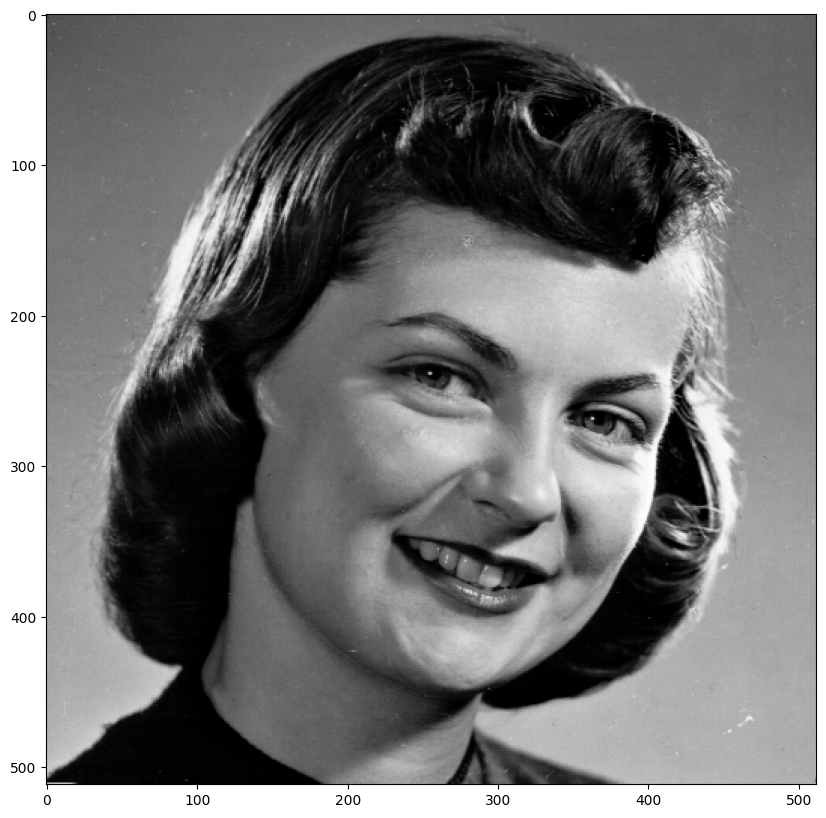

In [55]:
img = cv2.imread('../images/GirlFace.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap="gray")

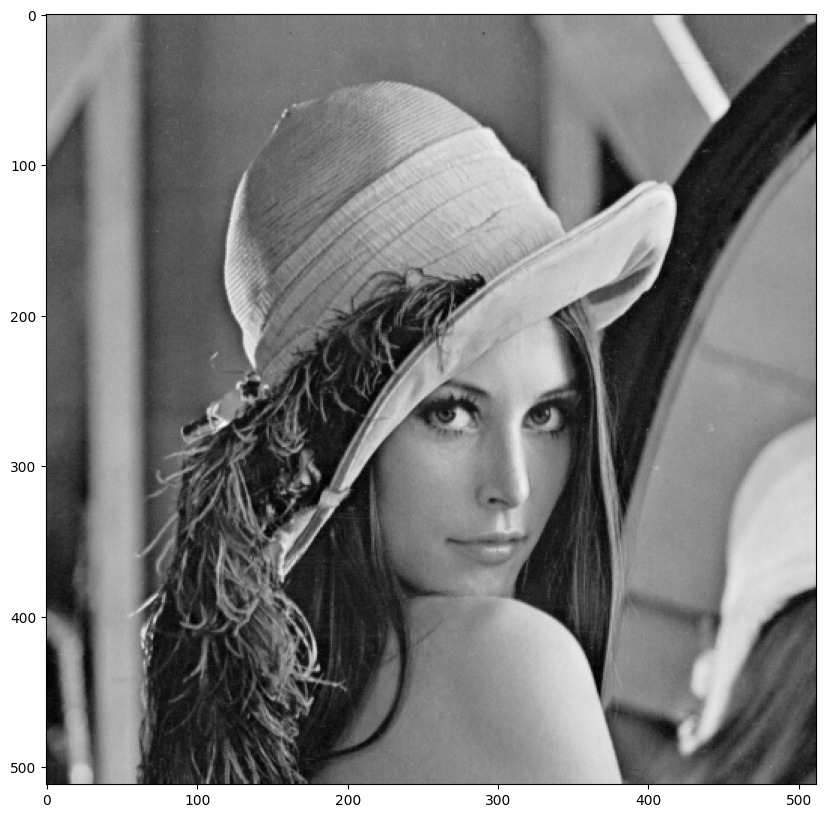

In [56]:
img_lena = cv2.imread('../images/Lena.bmp', cv2.IMREAD_GRAYSCALE)
plt.imshow(img_lena, cmap="gray")

### 1.1 Download the Girl Face image and plot a histogram of the grey levels it contains.

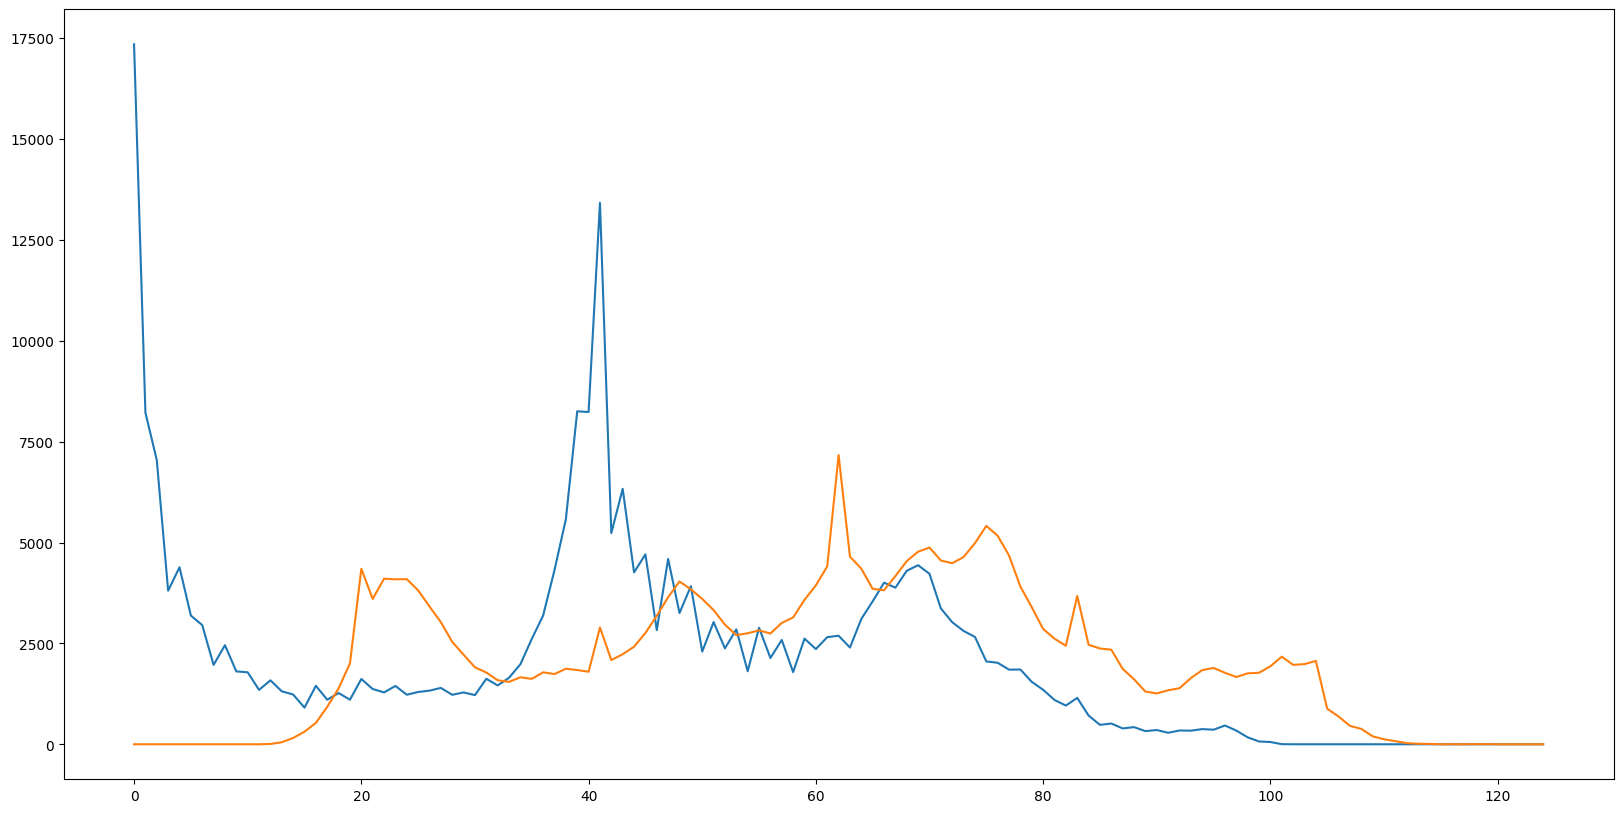

In [57]:
hist = cv2.calcHist([img], [0], None, [125], [0, 256])
plt.plot(hist)
hist = cv2.calcHist([img_lena], [0], None, [125], [0, 256])
plt.plot(hist)

### 1.2 Write a short program to threshold the image and try to identify a good threshold by trial and error. Create a ground truth segmentation.

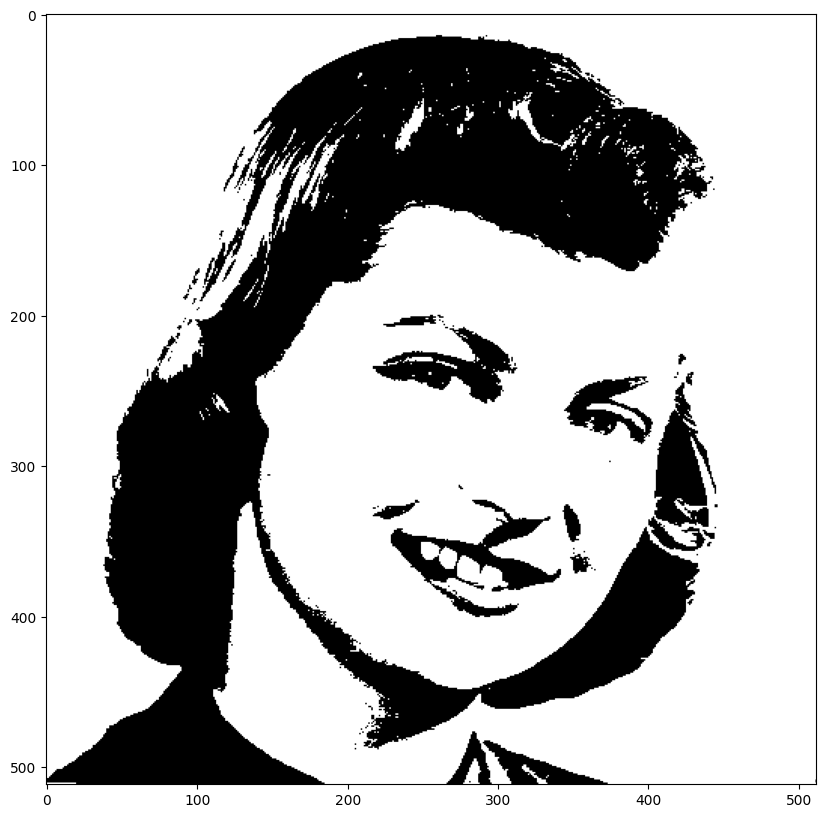

In [58]:
# Ground truth segmentation
segmentationGT = np.zeros(img.shape)
segmentationGT[img > 60] = 255
plt.imshow(segmentationGT, cmap="gray")

### 1.3 Use your ground truth segmentation to plot an ROC curve for your thresholding algorithm.

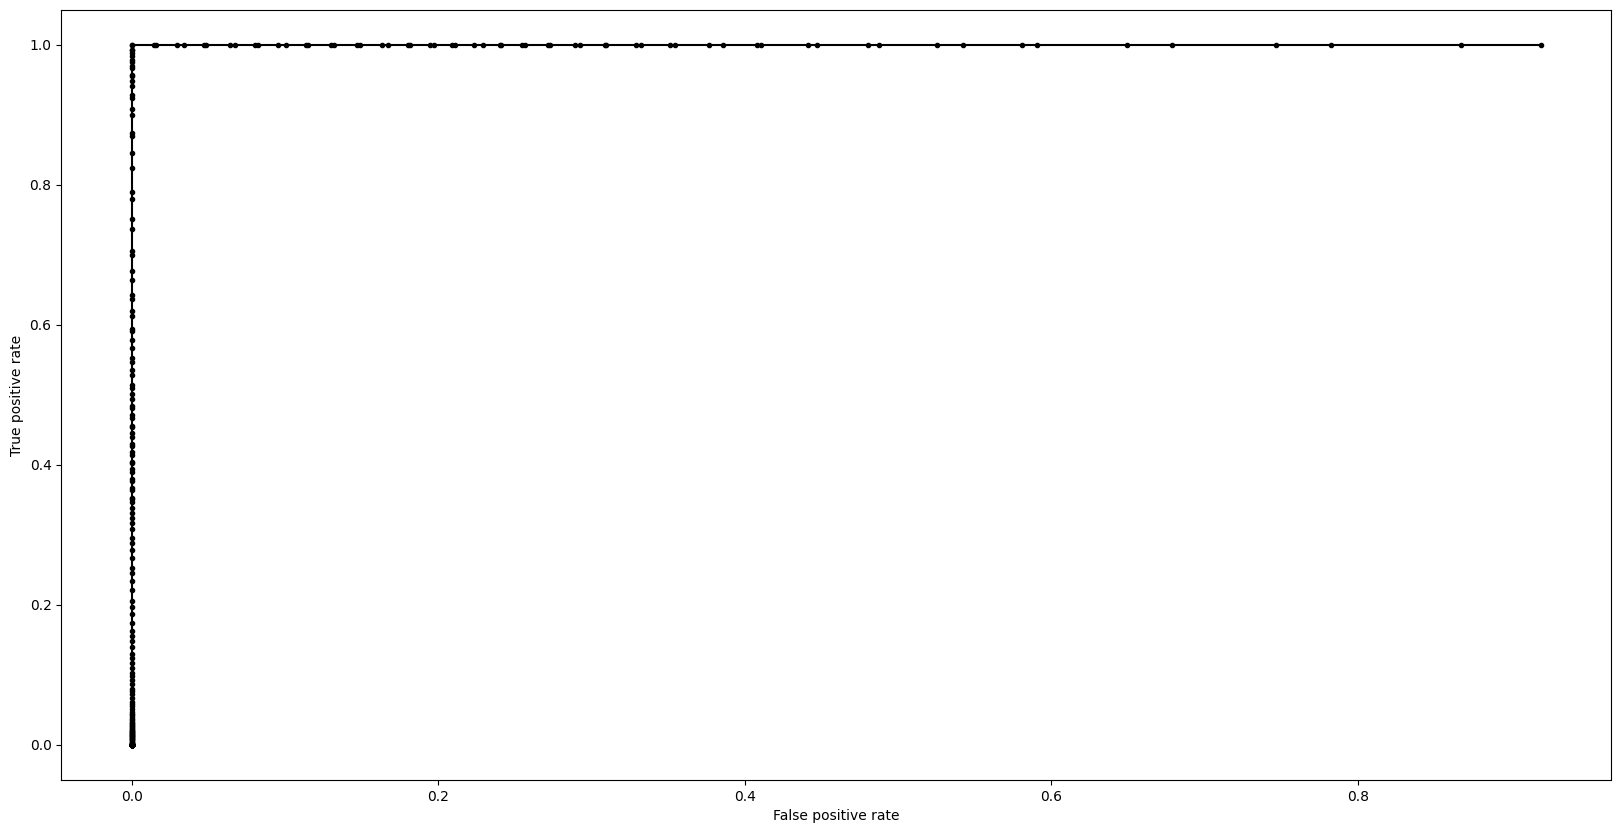

In [59]:
true_positive_rate = []
false_positive_rate = []
y_true = segmentationGT.flatten()

for i in range(0,256):
    segmentation = np.zeros(img.shape)
    segmentation[img > i] = 255
    y_pred = segmentation.flatten()
    
    cm = confusion_matrix(y_true, y_pred, labels=[0,255])

    true_positive = cm[1, 1]
    true_negative = cm[0, 0]
    false_positive = cm[0, 1]
    false_negative = cm[1, 0]
    
    true_positive_rate.append(true_positive / (true_positive + false_negative))
    false_positive_rate.append(false_positive / (false_positive + true_negative))
    
plt.plot(false_positive_rate, true_positive_rate, '-ok', markersize=3)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

# 2.1 Region Growing algorithm

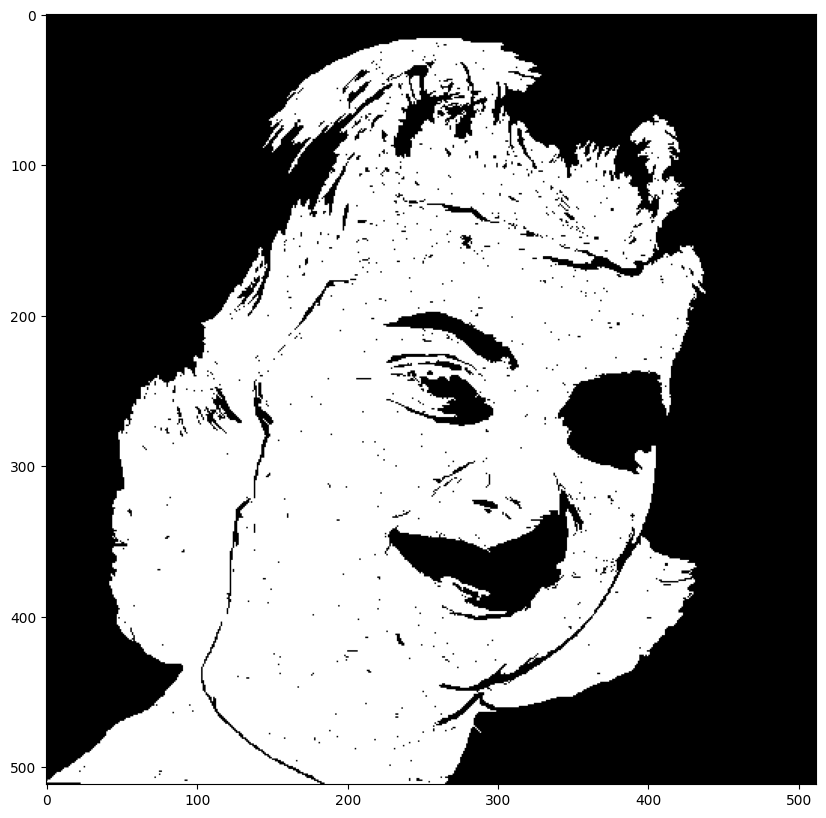

In [84]:
# region growing algorithm
def region_growing(img1, seeds):
    row,col = img1.shape
    segmented_img = np.zeros_like(img1).astype(np.uint32)
    visit = np.zeros_like(img1)
    for seed in seeds:
        x, y = seed
        dq = deque()
        pixel_val = 1.0 #img1[x,y]
        dq.append((x,y))
        segmented_img[x,y] = pixel_val
        while dq:
            x, y = dq.popleft()
            visit[x,y] = 1
            for i in range(x-1,x+2):
                for j in range(y-1,y+2):
                    if i >= 0 and i < row and j >= 0 and j < col:
                        if visit[i,j] == 0 and np.abs(img1[i,j] - img1[x,y] ) < 5:
                            dq.append((i,j))
                            segmented_img[i,j] = pixel_val
                            visit[i,j] = 1
    
    return segmented_img

# Create a copy of the image and resize it to speed up the algorithm
img_copy = Image.open('../images/GirlFace.png').convert('L')
img_copy = np.int16(img_copy)
seeds = np.random.randint(size=(1,2),low=0,high=img_copy.shape[0])
segmentation = region_growing(img_copy, seeds)
plt.imshow(segmentation, cmap="gray")

# 2.2 Mean-Shift algorithm

In [61]:
def printFull(cosa):
    np.set_printoptions(threshold=sys.maxsize)
    print(cosa)
    np.set_printoptions(threshold=30)
    
def recreate_image(values, labels, w, h):
    image = np.zeros((w, h))
    for i in range(w):
        for j in range(h):
            image[i][j] = values[labels[(i*w) + j]]
    return image

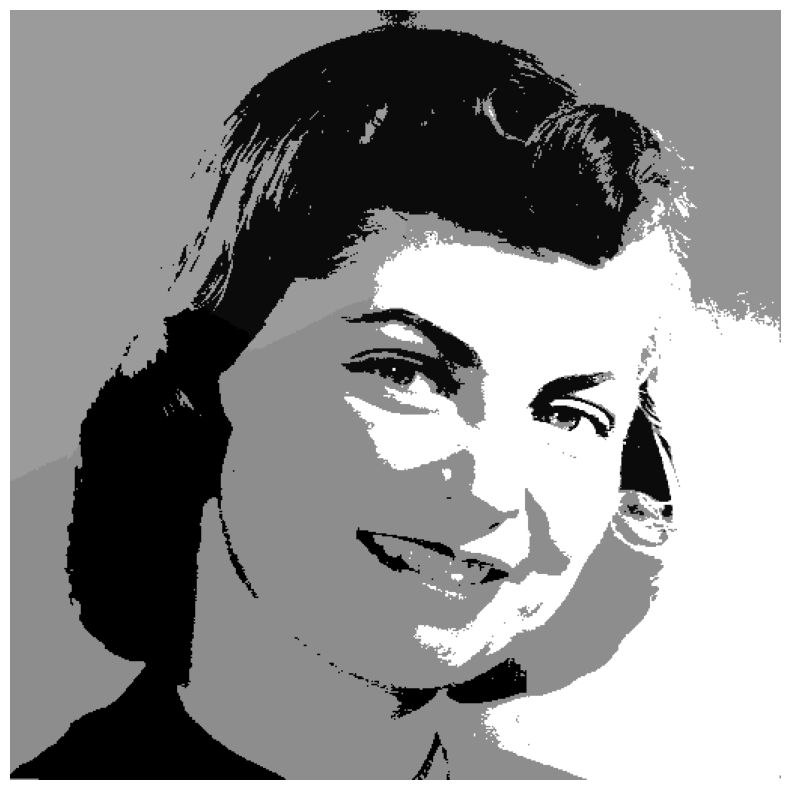

In [62]:
# Mean shift algorithm
def mean_shift(img, radius, min_bin_freq=1):
    data = np.array([(row, col, img[row][col]) for row in range(len(img)) for col in range(len(img[row]))], dtype=np.int32)
    data = MinMaxScaler(feature_range=(0, 1)).fit_transform(data)
    #fig = plt.figure()
    #ax = Axes3D(fig)
    #surf = ax.plot_trisurf(data[:, 0], data[:, 1], data[:, 2], cmap=matplotlib.cm.jet, linewidth=0.1)
    #fig.colorbar(surf, shrink=0.5, aspect=5)
    #plt.show()

    #Bin seeds
    bin_sizes = defaultdict(int)
    for point in data:
        binned_point = np.round(point / radius)
        bin_sizes[tuple(binned_point)] += 1
    seeds = np.array(
        [point for point, freq in bin_sizes.items() if freq >= min_bin_freq],
        dtype=np.float32,
    )
    seeds = seeds * radius
    nPoints, nDim = data.shape
    centerIntensity = {}
    neigh = NearestNeighbors(radius=radius).fit(data)
    seedCentroids = []
    
    #Get centroid per seed
    for centroid in seeds:
        while True:
            iNeigh = neigh.radius_neighbors([centroid], radius, return_distance=False)[0]
            points = data[iNeigh]
            if len(point) == 0:
                break
            oldCentroid = centroid
            centroid = np.mean(points, axis=0)
            if np.linalg.norm(centroid - oldCentroid) <= 0:
                break
        seedCentroids.append([tuple(centroid), len(points)])
    for i in range(len(seeds)):
            if seedCentroids[i][1]:
                centerIntensity[seedCentroids[i][0]] = seedCentroids[i][1]

    #Remove near duplicates
    intensitySorted = sorted(centerIntensity.items(), key=lambda tup: (tup[1], tup[0]), reverse=True,)
    sortedCenters = np.array([tup[0] for tup in intensitySorted])
    unique = np.ones(len(sortedCenters), dtype=bool)
    neigh = NearestNeighbors(radius=radius).fit(sortedCenters)
    for i, center in enumerate(sortedCenters):
        if unique[i]:
            neighbor_idxs = neigh.radius_neighbors([center], return_distance=False)[0]
            unique[neighbor_idxs] = 0
            unique[i] = 1
    centers = sortedCenters[unique]

    #Labels
    neigh = NearestNeighbors(n_neighbors=1).fit(centers)
    labels = np.zeros(nPoints, dtype=int)
    distances, idxs = neigh.kneighbors(data)
    labels = idxs.flatten()
    return centers, labels

# Use mean shift algorithm to segment the image
centers, labels = mean_shift(img, 0.3)
plt.figure(2)
plt.clf()
plt.axis('off')
plt.imshow(recreate_image(centers[:, 2:], labels, len(img), len(img[0])), cmap='gray')
plt.show()